In [106]:
import os
import numpy as np

import torch
M1 = False

if M1:
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
else:
    os.environ["CUDA_VISIBLE_DEVICES"]="1"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.is_available():
        print(torch.cuda.is_available())
        print(torch.cuda.device_count())
        print(torch.cuda.current_device())
        print(torch.cuda.get_device_name(torch.cuda.current_device()))

from functools import partial
import math
from tqdm import tqdm
import time as time

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torchmetrics.functional import structural_similarity_index_measure 
from torchmetrics.functional import peak_signal_noise_ratio 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy.io as sio
from astropy.io import fits

import large_scale_UQ as luq
from large_scale_UQ.utils import to_numpy, to_tensor
from convex_reg import utils as utils_cvx_reg



In [107]:
# Optimisation options for the MAP estimation
options = {"tol": 1e-5, "iter": 2500, "update_iter": 50, "record_iters": False}


In [108]:
# Optimisation options for the MAP estimation
options = {"tol": 1e-5, "iter": 5000, "update_iter": 50, "record_iters": False}
# Save param
# repo_dir = '/disk/xray0/tl3/repos/large-scale-UQ'
repo_dir = '/Users/tl/Documents/research/repos/proj-convex-UQ/large-scale-UQ'
save_dir = repo_dir + '/debug/sampling-outputs/'


In [109]:
img_name = 'M31'

# Load img
img_path = repo_dir + '/data/imgs/{:s}.fits'.format(img_name)
img_data = fits.open(img_path, memmap=False)

# Loading the image and cast it to float
img = np.copy(img_data[0].data)[0,:,:].astype(np.float64)
# Flipping data
img = np.flipud(img)

# Aliases
x = img
ground_truth = img


INSTRUME                                                                         [astropy.io.fits.card]


In [110]:
# %%
# Load op from X Cai
mask_path = repo_dir + '/data/operators_masks/fourier_mask.mat'
op_mask = sio.loadmat(mask_path)['Ma']

# Matlab's reshape works with 'F'-like ordering
mat_mask = np.reshape(np.sum(op_mask, axis=0), (256,256), order='F').astype(bool)

# %%

torch_img = torch.tensor(np.copy(img), dtype=torch.float, device=device).reshape((1,1) + img.shape)

# %%
dim = 256
phi = luq.operators.MaskedFourier_torch(
    dim=dim, 
    ratio=0.5 ,
    mask=mat_mask,
    norm='ortho',
    device=device
)



In [111]:
# Define X Cai noise level
sigma = 0.0024

y = phi.dir_op(torch_img).detach().cpu().squeeze().numpy()

# Generate noise
rng = np.random.default_rng(seed=0)
n = rng.normal(0, sigma, y[y!=0].shape)
# Add noise
y[y!=0] += n

# Observation
torch_y = torch.tensor(np.copy(y), device=device).reshape((1,) + img.shape)
x_init = torch.abs(phi.adj_op(torch_y))


In [112]:
x_init.shape

torch.Size([1, 256, 256])

In [113]:
# Define the likelihood
g = luq.operators.L2Norm_torch(
    sigma=sigma,
    data=torch_y,
    Phi=phi,
)
g.beta = 1.0 / sigma ** 2


# Define the wavelet dict
wavs_list = ['db8'] # ["db1", "db4"] 
levels = 4
reg_param = 2.e-3
# Define the l1 norm with dict psi
# gamma = torch.max(torch.abs(psi.dir_op(y_torch))) * reg_param
psi = luq.operators.DictionaryWv_torch(wavs_list, levels)

h = luq.operators.L1Norm_torch(1., psi, op_to_coeffs=True)
gamma = h._get_max_abs_coeffs(h.dir_op(torch.clone(x_init))) * reg_param
h.gamma = gamma
h.beta = 1.0

print('gamma: ', gamma)

f = luq.operators.RealProx_torch()


gamma:  0.007339946269989014


In [114]:
gamma/2.

0.003669973134994507

In [115]:
x_init.shape

torch.Size([1, 256, 256])

In [116]:
alpha = 1. / (1. + g.beta)

x_hat, diagnostics = luq.optim.FB_torch(
    x_init,
    options=options,
    g=g,
    f=f,
    h=h,
    alpha=alpha,
    tau=1.,
    viewer=None
)


Running Base Forward Backward
[Forward Backward] 0 out of 5000 iterations, tol = 4.08e-01
[Forward Backward] 0 out of 5000 iterations, tol = 4.08e-01
[Forward Backward] 1 out of 5000 iterations, tol = 1.52e-01
[Forward Backward] 2 out of 5000 iterations, tol = 6.92e-02
[Forward Backward] 3 out of 5000 iterations, tol = 3.47e-02
[Forward Backward] 4 out of 5000 iterations, tol = 1.97e-02
[Forward Backward] 5 out of 5000 iterations, tol = 1.34e-02
[Forward Backward] 6 out of 5000 iterations, tol = 1.08e-02
[Forward Backward] 7 out of 5000 iterations, tol = 9.54e-03
[Forward Backward] 8 out of 5000 iterations, tol = 8.79e-03
[Forward Backward] 9 out of 5000 iterations, tol = 8.22e-03
[Forward Backward] 10 out of 5000 iterations, tol = 7.77e-03
[Forward Backward] 11 out of 5000 iterations, tol = 7.36e-03
[Forward Backward] 12 out of 5000 iterations, tol = 7.00e-03
[Forward Backward] 13 out of 5000 iterations, tol = 6.68e-03
[Forward Backward] 14 out of 5000 iterations, tol = 6.39e-03
[Forw

In [117]:

x_hat.shape


torch.Size([1, 1, 256, 256])

In [118]:

x_hat_np = luq.utils.to_numpy(x_hat)


In [119]:
x_hat_np.imag

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

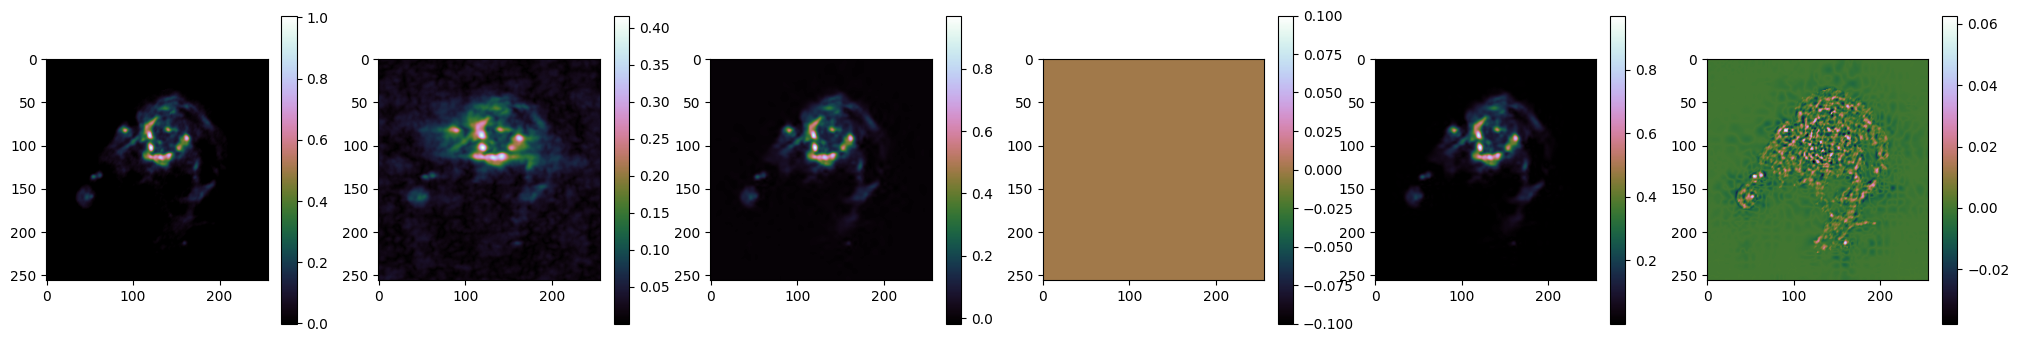

In [120]:
cmap='cubehelix'

plt.figure(figsize=(25,4))

plt.subplot(161)
plt.imshow(ground_truth, cmap=cmap)
plt.colorbar()

plt.subplot(162)
plt.imshow(luq.utils.to_numpy(x_init), cmap=cmap)
plt.colorbar()

plt.subplot(163)
plt.imshow(x_hat_np.real, cmap=cmap)
plt.colorbar()

plt.subplot(164)
plt.imshow(x_hat_np.imag, cmap=cmap)
plt.colorbar()

plt.subplot(165)
plt.imshow(np.abs(x_hat_np), cmap=cmap)
plt.colorbar()

plt.subplot(166)
plt.imshow(ground_truth - np.abs(x_hat_np), cmap=cmap)
plt.colorbar()


### Now numpy version

In [121]:
import optimusprimal as optpr


In [122]:
# A mock radio imaging forward model with half of the Fourier coefficients masked
phi_np = luq.operators.MaskedFourier_numpy(
    dim=dim, 
    ratio=0.5 ,
    mask=mat_mask,
    norm='ortho',
)

In [123]:

y_np = phi_np.dir_op(ground_truth)
y_np += n
x_init_np = np.abs(phi_np.adj_op(y_np))



In [124]:

# reg_param_FB = 5e-2

# Define the grad
g_np = optpr.grad_operators.l2_norm(sigma, y_np, phi_np)
g_np.beta = 1.0 / sigma ** 2

# Define the wavelet dict
psi_np = optpr.linear_operators.dictionary(wavs_list, levels, ground_truth.shape)  # Wavelet linear operator

# Define the l1 norm prox with the dict psi
h_np = optpr.prox_operators.l1_norm(1., psi_np)
gamma_np = np.max(np.abs(psi_np.dir_op(abs(phi_np.adj_op(y_np))))) * reg_param
h_np.gamma = gamma_np
h_np.beta = 1.0
print('gamma_np: ', gamma_np)

# Real prox 
f_np = optpr.prox_operators.real_prox()
# f_np = None


gamma_np:  0.0073399448136145734


In [125]:

alpha = 1. / (g_np.beta + 1.)
wvlt_FB_best_estimate, wvlt_FB_diagnostics = optpr.forward_backward.FB(
    x_init=x_init_np, options=options, g=g_np, f=f_np, h=h_np, alpha=alpha, tau=1.
)


2023-03-27 16:52:09,602 - Optimus Primal - INFO - Running Base Forward Backward
2023-03-27 16:52:09,611 - Optimus Primal - INFO - [Forward Backward] 0 out of 5000 iterations, tol = 0.407776
2023-03-27 16:52:09,996 - Optimus Primal - INFO - [Forward Backward] 50 out of 5000 iterations, tol = 0.000955
2023-03-27 16:52:10,328 - Optimus Primal - INFO - [Forward Backward] converged in 95 iterations


In [126]:
wvlt_FB_best_estimate

array([[-7.09670448e-05+1.87417868e-20j, -1.42454367e-04+2.74806641e-20j,
        -1.99397904e-04+3.46261413e-20j, ...,
         8.90443125e-05-9.93751944e-21j,  6.82366338e-05-9.90436334e-21j,
         3.58082978e-05-9.99839813e-21j],
       [-4.28256786e-05+1.70890490e-20j, -1.06280033e-04+2.62530094e-20j,
        -1.58763359e-04+3.38606699e-20j, ...,
         7.96205957e-05-6.10762576e-21j,  5.30231661e-05-6.04501095e-21j,
         1.01135805e-05-6.17789249e-21j],
       [ 4.86276558e-06+1.23932323e-20j, -1.45519125e-05+1.71691205e-20j,
        -2.84924983e-05+2.07953026e-20j, ...,
         5.67055338e-05-1.58362406e-21j,  2.22341863e-05-1.49295081e-21j,
        -3.02764198e-05-1.67110372e-21j],
       ...,
       [-1.04910830e-04+1.39502831e-20j, -1.19713285e-04+1.21693455e-20j,
        -8.56221808e-05+1.03456830e-20j, ...,
        -4.05821500e-06-2.84209992e-22j, -1.18837232e-06-1.08843558e-21j,
        -1.12819983e-05-2.01618100e-21j],
       [-1.10303353e-04+1.36265179e-20j, -1.

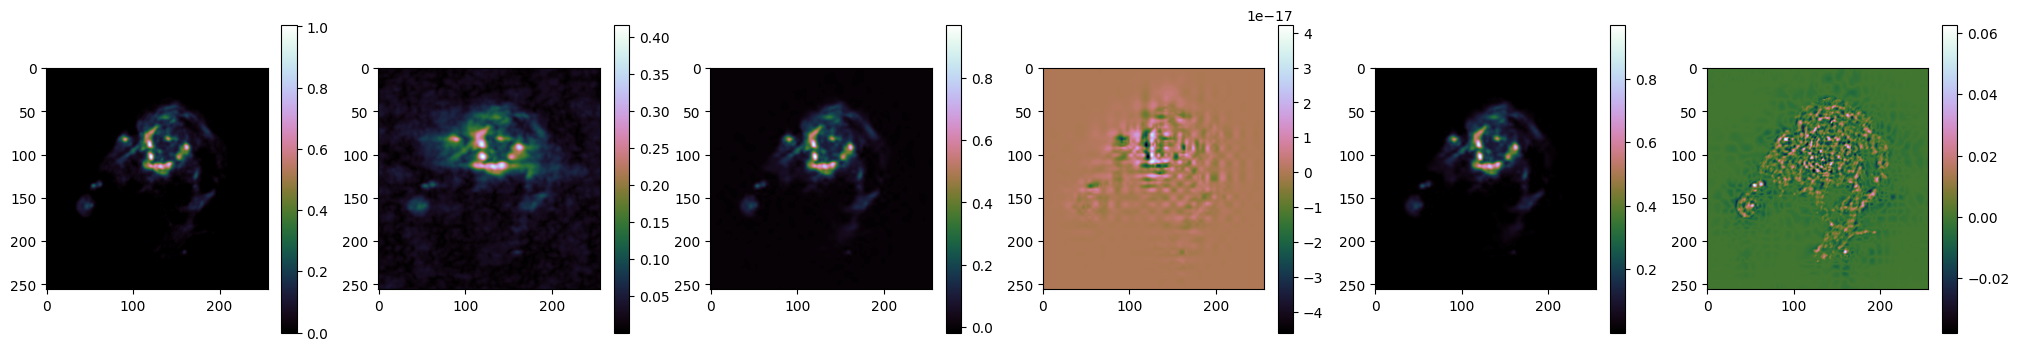

In [127]:


cmap='cubehelix'

plt.figure(figsize=(25,4))

plt.subplot(161)
plt.imshow(ground_truth, cmap=cmap)
plt.colorbar()

plt.subplot(162)
plt.imshow(x_init_np, cmap=cmap)
plt.colorbar()

plt.subplot(163)
plt.imshow(wvlt_FB_best_estimate.real, cmap=cmap)
plt.colorbar()

plt.subplot(164)
plt.imshow(wvlt_FB_best_estimate.imag, cmap=cmap)
plt.colorbar()

plt.subplot(165)
plt.imshow(np.abs(wvlt_FB_best_estimate), cmap=cmap)
plt.colorbar()

plt.subplot(166)
plt.imshow(ground_truth - np.abs(wvlt_FB_best_estimate), cmap=cmap)
plt.colorbar()



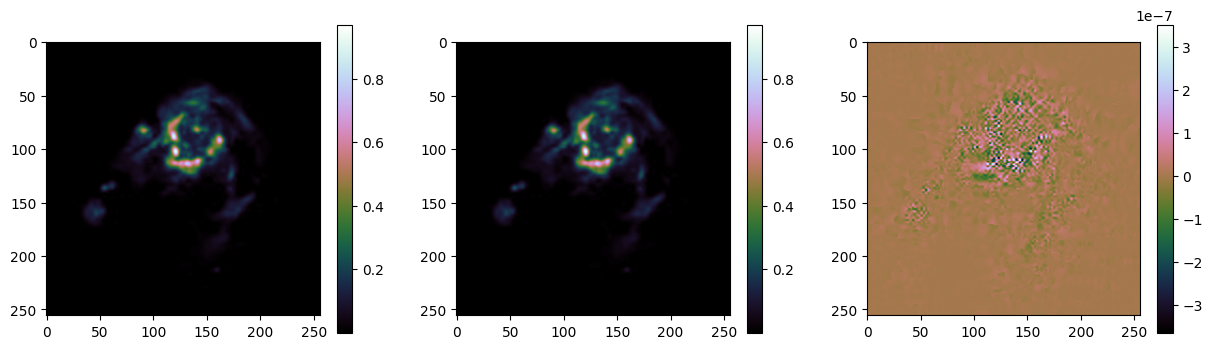

In [128]:

plt.figure(figsize=(15,4))

plt.subplot(131)
plt.imshow(np.abs(x_hat_np), cmap=cmap)
plt.colorbar()

plt.subplot(132)
plt.imshow(np.abs(wvlt_FB_best_estimate), cmap=cmap)
plt.colorbar()

plt.subplot(133)
plt.imshow(np.abs(x_hat_np) - np.abs(wvlt_FB_best_estimate), cmap=cmap)
plt.colorbar()
plt.show()




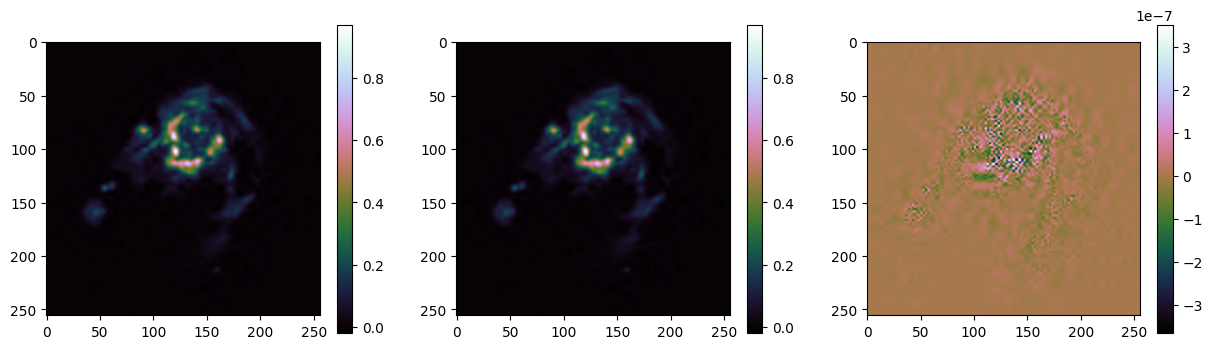

In [129]:
plt.figure(figsize=(15,4))

plt.subplot(131)
plt.imshow(x_hat_np.real, cmap=cmap)
plt.colorbar()

plt.subplot(132)
plt.imshow(wvlt_FB_best_estimate.real, cmap=cmap)
plt.colorbar()

plt.subplot(133)
plt.imshow(x_hat_np.real - wvlt_FB_best_estimate.real, cmap=cmap)
plt.colorbar()
plt.show()


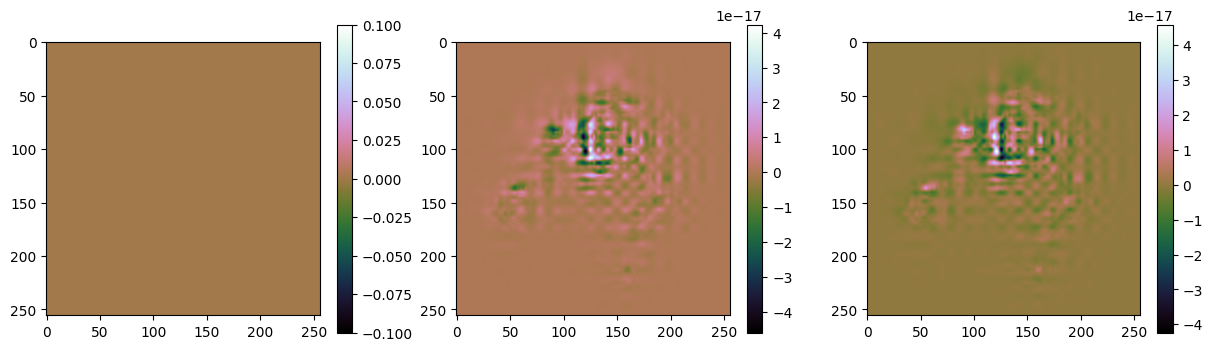

In [130]:
plt.figure(figsize=(15,4))

plt.subplot(131)
plt.imshow(x_hat_np.imag, cmap=cmap)
plt.colorbar()

plt.subplot(132)
plt.imshow(wvlt_FB_best_estimate.imag, cmap=cmap)
plt.colorbar()

plt.subplot(133)
plt.imshow(x_hat_np.imag - wvlt_FB_best_estimate.imag, cmap=cmap)
plt.colorbar()
plt.show()
